---
Author: Mustapha Bouhsen <br>
[LinkedIn](https://www.linkedin.com/in/mustapha-bouhsen/)<br>
[Git](https://github.com/mus514)<br>
Date: February 9, 2024<br>
---

# Usefull function for the daily loads

In [0]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
import matplotlib.ticker as mtick
from sklearn.preprocessing import LabelEncoder
import scipy.stats as ss
from math import pi

from scipy.optimize import minimize, Bounds, LinearConstraint

In [0]:
# Setting the matplotlib format to 'retina' for better display quality
set_matplotlib_formats('retina')
plt.style.use('seaborn-notebook')

/root/.ipykernel/826/command-3996405578401645-4036587617:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


## Load the data

In [0]:
returns = spark.sql("SELECT * FROM stocks_returns").toPandas()
prices = spark.sql("SELECT * FROM stocks_prices").toPandas()

In [0]:
#-----------------------------------------
# Garch(1, 1) Model
#-----------------------------------------
def garch(theta, r):
    """
    Compute the GARCH(1,1) volatility using the given parameters.

    Parameters:
    - theta (list): List containing GARCH parameters in the following order:
        - w (float): Constant term.
        - a (float): Coefficient for the lagged squared return term.
        - b (float): Coefficient for the lagged volatility term.
    - r (numpy.ndarray): Array of financial returns.

    Returns:
    - numpy.ndarray: Array containing the GARCH(1,1) volatility estimates for each period.
    """
    # Extract the parameters
    w = theta[0]
    a = theta[1]
    b = theta[2]

    # Initialize array to store volatility estimates
    T = len(r)
    sigma = np.zeros(T + 1)
    sigma[0] = w / (1 - a - b)

    # Iterate to calculate volatility estimates
    for i in range(1, T + 1):
        sigma[i] = w + a * (r[i - 1] ** 2) + b * sigma[i - 1]

    return sigma

In [0]:
#-----------------------------------------
# Normal distribution to minimize
#-----------------------------------------
def log_normal_likely(theta, r):
    """
    Calculate the log-likelihood of a GARCH(1,1) model assuming normally distributed returns.

    Parameters:
    - theta (list): List containing GARCH parameters in the following order:
        - w (float): Constant term.
        - a (float): Coefficient for the lagged squared return term.
        - b (float): Coefficient for the lagged volatility term.
    - r (numpy.ndarray): Array of financial returns.

    Returns:
    - float: Log-likelihood value for the given GARCH parameters and returns.
    """
    # Calculate GARCH(1,1) volatility using the provided parameters
    sigma = garch(theta, r)[:-1]

    # Calculate log-likelihood
    ll = (-np.log(np.sqrt(2 * pi * sigma)) - 0.5 * (r ** 2) / sigma).sum()

    # Check for finite log-likelihood values
    if np.isfinite(ll):
        return ll
    else:
        return 1e10

In [0]:
#-----------------------------------------
# Forcast the volatility for the next day
#-----------------------------------------
def forecast_vol(r):
    """
    Forecast the volatility using a GARCH(1,1) model based on historical financial returns.

    Parameters:
    - r (numpy.ndarray): Array of historical financial returns.

    Returns:
    - numpy.ndarray: Array containing the forecasted GARCH(1,1) volatility for each period.
    """
    # Initial guess for GARCH parameters
    initial_guess = [0.01, 0.1, 0.8]

    # Define negative log-likelihood function
    neg_log_likelihood = lambda theta: -log_normal_likely(theta, r)

    # Define parameter bounds
    bounds = [(0, 1), (0.001, 0.99), (0.001, 0.99)]

    # Use the minimize function with the constraints
    result = minimize(neg_log_likelihood, initial_guess, method='BFGS', bounds=bounds)

    # Extract the optimal parameters
    optimal_theta = result.x

    # Calculate GARCH(1,1) volatility using optimal parameters
    sigma = garch(optimal_theta, r)

    return sigma

## Example of use

In [0]:
#-----------------------------------------
# list of return for Microsoft
#-----------------------------------------
r = returns["msft"]
date = returns["date"]

In [0]:
#-----------------------------------------
# list of volatility usinig GARCH(1, 1)
#-----------------------------------------
sigma = forecast_vol(r)

<AxesSubplot:xlabel='date', ylabel='msft'>

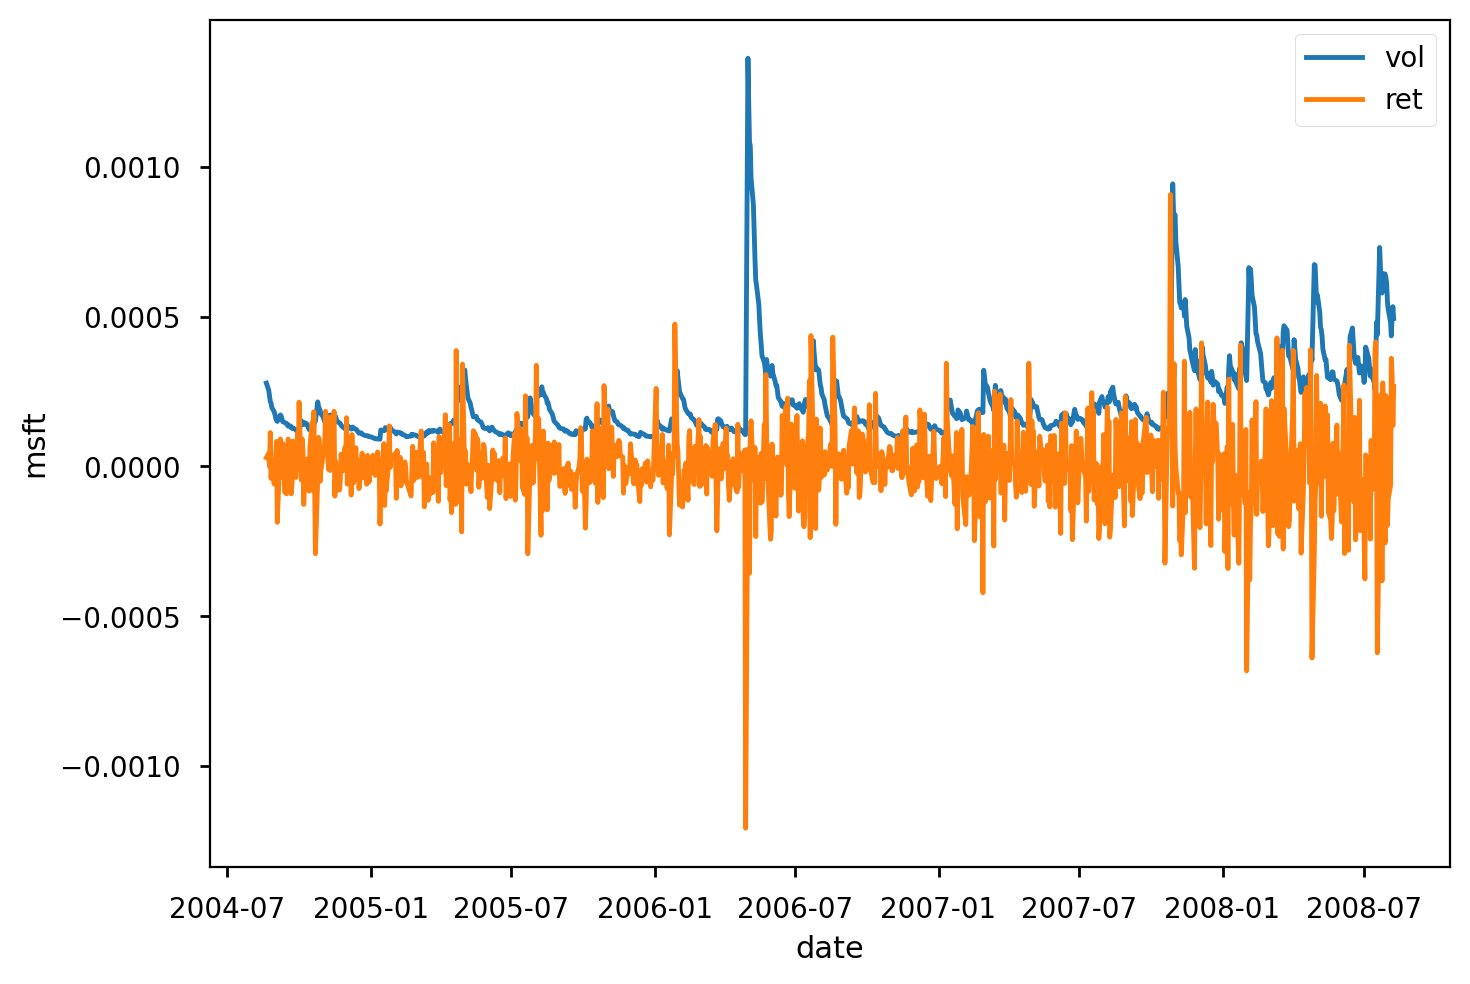

In [0]:
#-----------------------------------------
# Volatily and return for the first 1000 days
#-----------------------------------------
sns.lineplot(y=sigma[0:1000], x = date[0:1000], label="vol")
sns.lineplot(y=r[0:1000]/100, x = date[0:1000], label="ret")